In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/onlinedetailsdataset01/Online Retail.xlsx


In [2]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from datetime import datetime
from pandas.plotting import scatter_matrix

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.neighbors import NearestNeighbors

from scipy.cluster.hierarchy import dendrogram, linkage

RANDOM_STATE = 42
DATA_PATH = "/kaggle/input/onlinedetailsdataset01/Online Retail.xlsx"  # e.g., "/path/to/Online Retail.xlsx"
COUNTRY_FILTER = "United Kingdom" # As per assignment

# Import Data Set and Describe

In [3]:
import pandas as pd

# Load Excel dataset
df = pd.read_excel("/kaggle/input/onlinedetailsdataset01/Online Retail.xlsx")

# Get summary statistics (numeric columns)
print(df.head())

# Check missing values per column
print(df.isnull().sum())

# Calculate percentage of null values
null_percentage = (df.isnull().sum() / len(df)) * 100

# Show nicely
print(null_percentage)


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [4]:
# 1. Remove records with missing CustomerID
df = df.dropna(subset=["CustomerID"])

# 2. Filter for a single country (e.g., United Kingdom)
df = df[df["Country"] == "United Kingdom"]

# 3. Remove cancelled orders (InvoiceNo starting with "C")
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]

# Final cleaned dataset
print(df.shape)
df.head()# Add TotalPurchase column
df["TotalPurchase"] = df["Quantity"] * df["UnitPrice"]

# Reference date = max InvoiceDate in dataset
ref_date = df["InvoiceDate"].max()

# Group by CustomerID
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (ref_date - x.max()).days,  # Recency
    "InvoiceNo": "nunique",                              # Frequency
    "TotalPurchase": "sum"                               # Monetary
})


(354345, 8)


In [5]:
# Rename columns
rfm.rename(columns={
    "InvoiceDate": "Recency",
    "InvoiceNo": "Frequency",
    "TotalPurchase": "Monetary"
}, inplace=True)

# Reset index for clarity
rfm = rfm.reset_index()
print("RFM sample:\n", rfm.head())
print("\nRFM summary:\n", rfm.describe())

RFM sample:
    CustomerID  Recency  Frequency  Monetary
0     12346.0      325          1  77183.60
1     12747.0        1         11   4196.01
2     12748.0        0        210  33719.73
3     12749.0        3          5   4090.88
4     12820.0        2          4    942.34

RFM summary:
          CustomerID      Recency    Frequency       Monetary
count   3921.000000  3921.000000  3921.000000    3921.000000
mean   15561.471563    91.188472     4.246111    1863.910113
std     1576.823683    99.528995     7.205750    7481.922217
min    12346.000000     0.000000     1.000000       0.000000
25%    14208.000000    17.000000     1.000000     300.040000
50%    15569.000000    50.000000     2.000000     651.820000
75%    16913.000000   142.000000     5.000000    1575.890000
max    18287.000000   373.000000   210.000000  259657.300000


In [6]:
from sklearn.preprocessing import StandardScaler

# -----------------------------
# 4. Standardization
# -----------------------------

# Select RFM features only
rfm_features = rfm[["Recency", "Frequency", "Monetary"]]

# Standardize
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

# Convert back to DataFrame for easier interpretation
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=["Recency", "Frequency", "Monetary"])
rfm_scaled_df["CustomerID"] = rfm["CustomerID"].values

# -----------------------------
# 5. Output check
# -----------------------------
print("\nStandardized RFM sample:\n", rfm_scaled_df.head())
print("\nMeans after scaling (should be ~0):\n", rfm_scaled_df[["Recency","Frequency","Monetary"]].mean())
print("\nStd after scaling (should be ~1):\n", rfm_scaled_df[["Recency","Frequency","Monetary"]].std())



Standardized RFM sample:
     Recency  Frequency   Monetary  CustomerID
0  2.349480  -0.450546  10.068174     12346.0
1 -0.906268   0.937411   0.311738     12747.0
2 -0.916317  28.557767   4.258248     12748.0
3 -0.886171   0.104637   0.297685     12749.0
4 -0.896220  -0.034159  -0.123189     12820.0

Means after scaling (should be ~0):
 Recency     -6.025388e-17
Frequency   -4.349152e-17
Monetary    -1.993361e-17
dtype: float64

Std after scaling (should be ~1):
 Recency      1.000128
Frequency    1.000128
Monetary     1.000128
dtype: float64


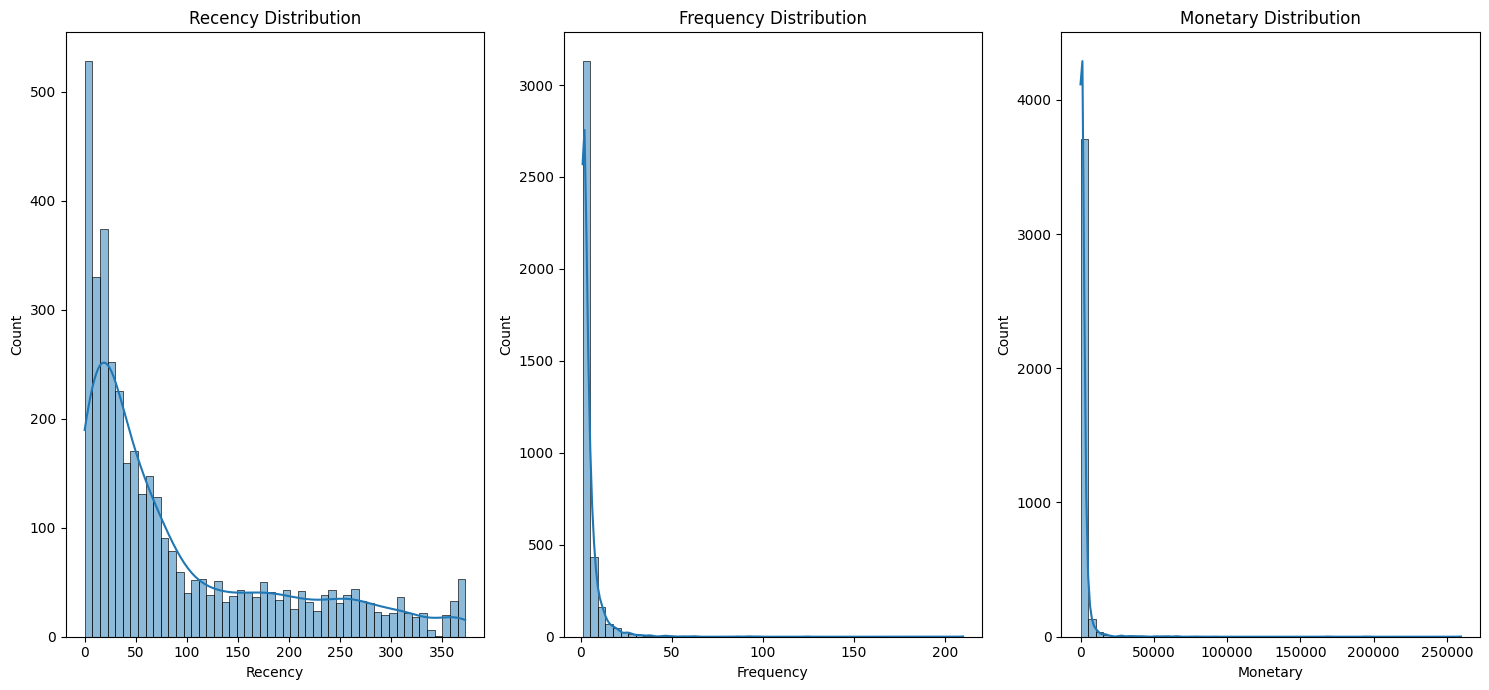

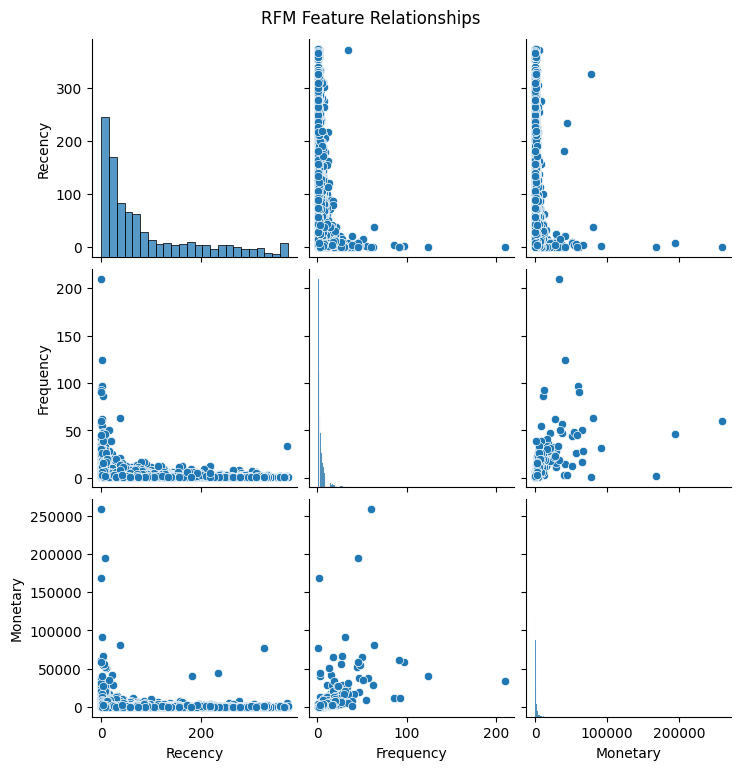

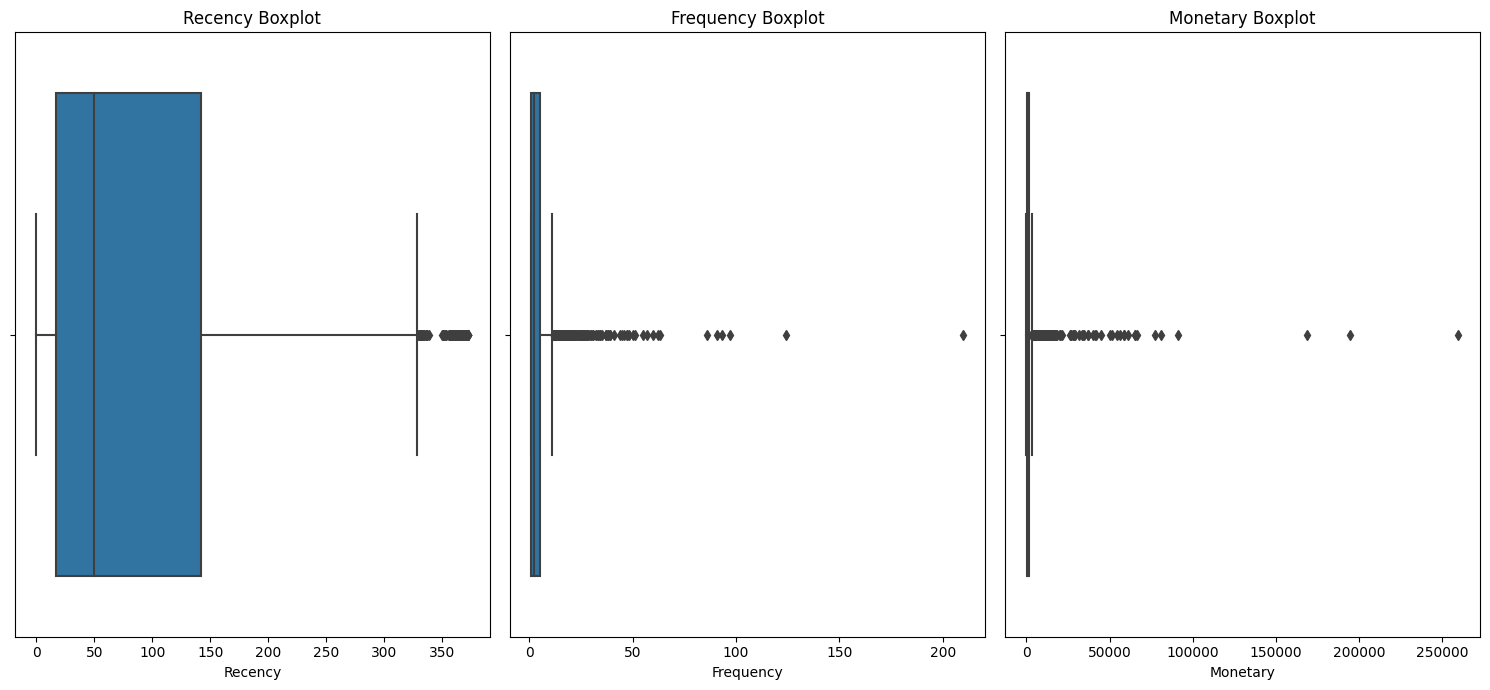

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# 1. Histograms for each RFM feature
# -----------------------------
plt.figure(figsize=(15, 7))

for i, col in enumerate(["Recency", "Frequency", "Monetary"], 1):
    plt.subplot(1, 3, i)
    sns.histplot(rfm[col], bins=50, kde=True)
    plt.title(f'{col} Distribution')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

# -----------------------------
# 2. Pairplot to see relationships between RFM features
# -----------------------------
sns.pairplot(rfm[["Recency", "Frequency", "Monetary"]])
plt.suptitle("RFM Feature Relationships", y=1.02)
plt.show()

# -----------------------------
# 3. Boxplots to check for outliers
# -----------------------------
plt.figure(figsize=(15, 7))

for i, col in enumerate(["Recency", "Frequency", "Monetary"], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=rfm[col])
    plt.title(f'{col} Boxplot')

plt.tight_layout()
plt.show()


# Data PreProcessing

In [8]:
def load_online_retail(path):
    if not os.path.exists(path):
        raise FileNotFoundError(
            f"File not found: {path}\n"
            "Please download the UCI 'Online Retail' dataset and place it here.\n"
            "Expected file: Online Retail.xlsx (or set DATA_PATH to your CSV)."
        )
    ext = os.path.splitext(path)[1].lower()
    if ext in [".xlsx", ".xls"]:
        df = pd.read_excel(path)
    else:
        # Fallback for CSVs exported by Excel
        df = pd.read_csv(path, encoding="latin1", parse_dates=["InvoiceDate"], dayfirst=True)
    return df

df_raw = load_online_retail(DATA_PATH)

# Standard column name expectations (UCI format)
expected_cols = {"InvoiceNo","StockCode","Description","Quantity","InvoiceDate","UnitPrice","CustomerID","Country"}
missing = expected_cols - set(df_raw.columns)
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

# Clean data:
# 1) Remove missing CustomerID
df = df_raw.dropna(subset=["CustomerID"]).copy()

# 2) Filter to single country to reduce noise
df = df[df["Country"] == COUNTRY_FILTER].copy()

# 3) Remove cancelled orders: InvoiceNo starting with 'C'
df["InvoiceNo"] = df["InvoiceNo"].astype(str)
df = df[~df["InvoiceNo"].str.startswith("C")].copy()

# 4) Ensure types and compute line value
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["CustomerID"]  = df["CustomerID"].astype(int)
df["Quantity"]    = pd.to_numeric(df["Quantity"], errors="coerce").fillna(0)
df["UnitPrice"]   = pd.to_numeric(df["UnitPrice"], errors="coerce").fillna(0.0)

# Remove negative or zero quantities/prices if desired (common cleanup)
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)].copy()


In [9]:

# RFM feature engineering:
# Recency: days since last purchase (relative to dataset max date)
max_date = df["InvoiceDate"].max()
rfm = (
    df.assign(Amount=df["Quantity"] * df["UnitPrice"])
      .groupby("CustomerID")
      .agg(
          Recency=("InvoiceDate", lambda s: (max_date - s.max()).days),
          Frequency=("InvoiceNo", "nunique"),
          Monetary=("Amount", "sum")
      )
      .reset_index()
)

# Standardize RFM
scaler = StandardScaler()
rfm_scaled = rfm.copy()
rfm_scaled[["Recency","Frequency","Monetary"]] = scaler.fit_transform(rfm[["Recency","Frequency","Monetary"]])

print("RFM head (unscaled):")
display(rfm.head())

print("RFM head (scaled):")
display(rfm_scaled.head())


RFM head (unscaled):


,CustomerID,Recency,Frequency,Monetary
0,12346,325,1,77183.60
1,12747,1,11,4196.01
2,12748,0,209,33719.73
3,12749,3,5,4090.88
4,12820,2,4,942.34


RFM head (scaled):


,CustomerID,Recency,Frequency,Monetary
0,12346,2.349165,-0.451000,10.066906
1,12747,-0.906425,0.938220,0.311637
2,12748,-0.916473,28.444775,4.257675
3,12749,-0.886328,0.104688,0.297586
4,12820,-0.896376,-0.034234,-0.123237


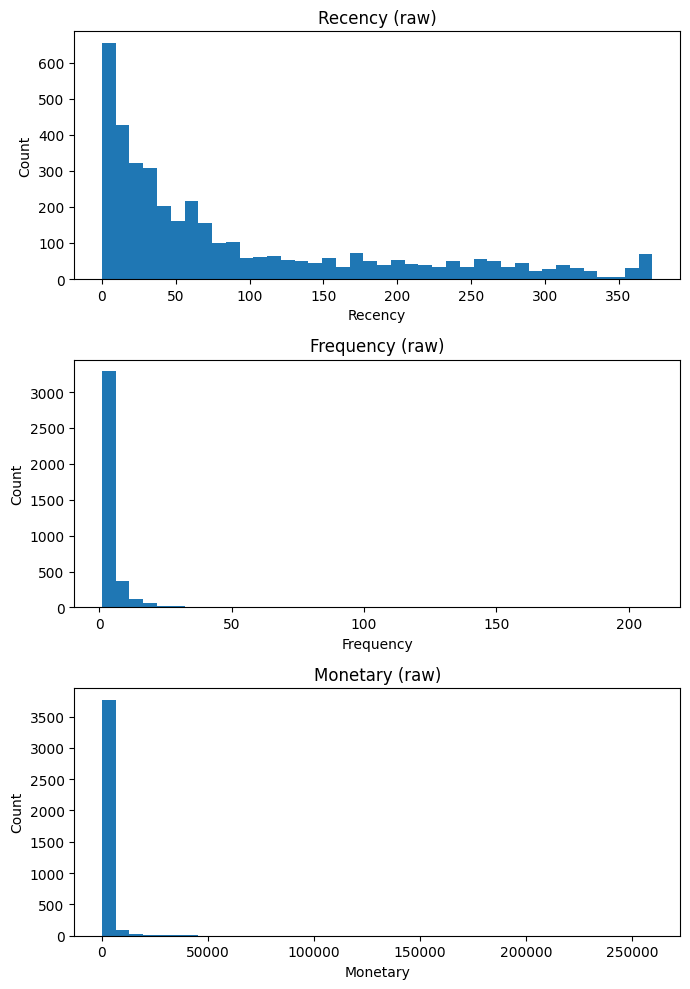

In [10]:
# === Histograms (RAW RFM) — stacked vertically ===
import matplotlib.pyplot as plt

cols = ["Recency", "Frequency", "Monetary"]
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 10))  # 3x1 grid

for ax, col in zip(axes, cols):
    ax.hist(rfm[col].values, bins=40)
    ax.set_title(f"{col} (raw)")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()


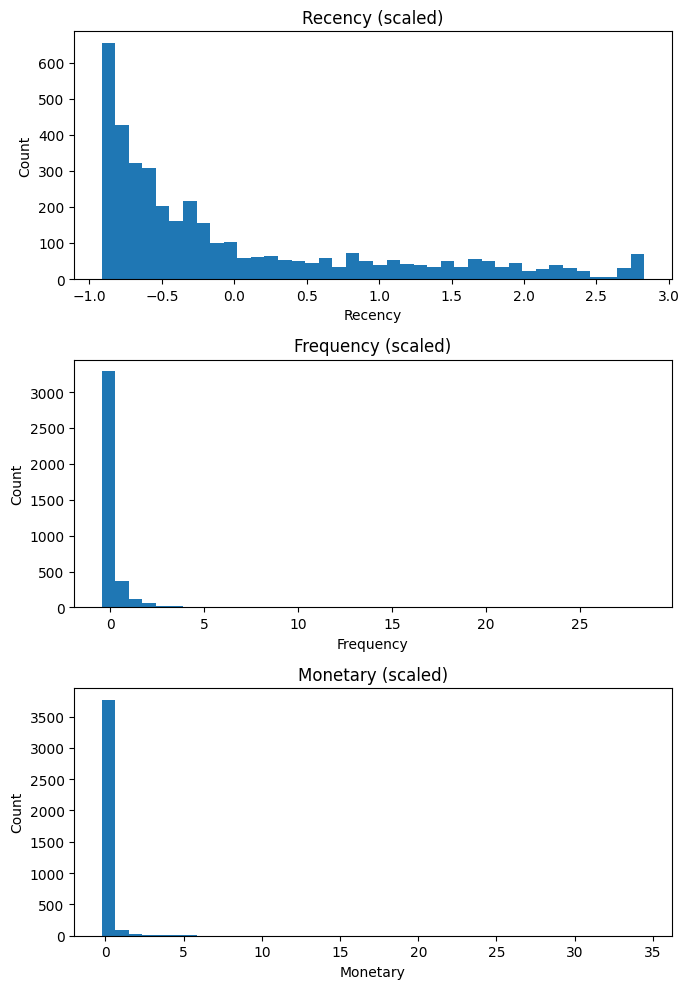

In [11]:
# === Histograms (SCALED RFM) ===
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 10)) 
for ax, col in zip(axes, ["Recency", "Frequency", "Monetary"]):
    ax.hist(rfm_scaled[col].values, bins=40)
    ax.set_title(f"{col} (scaled)")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()


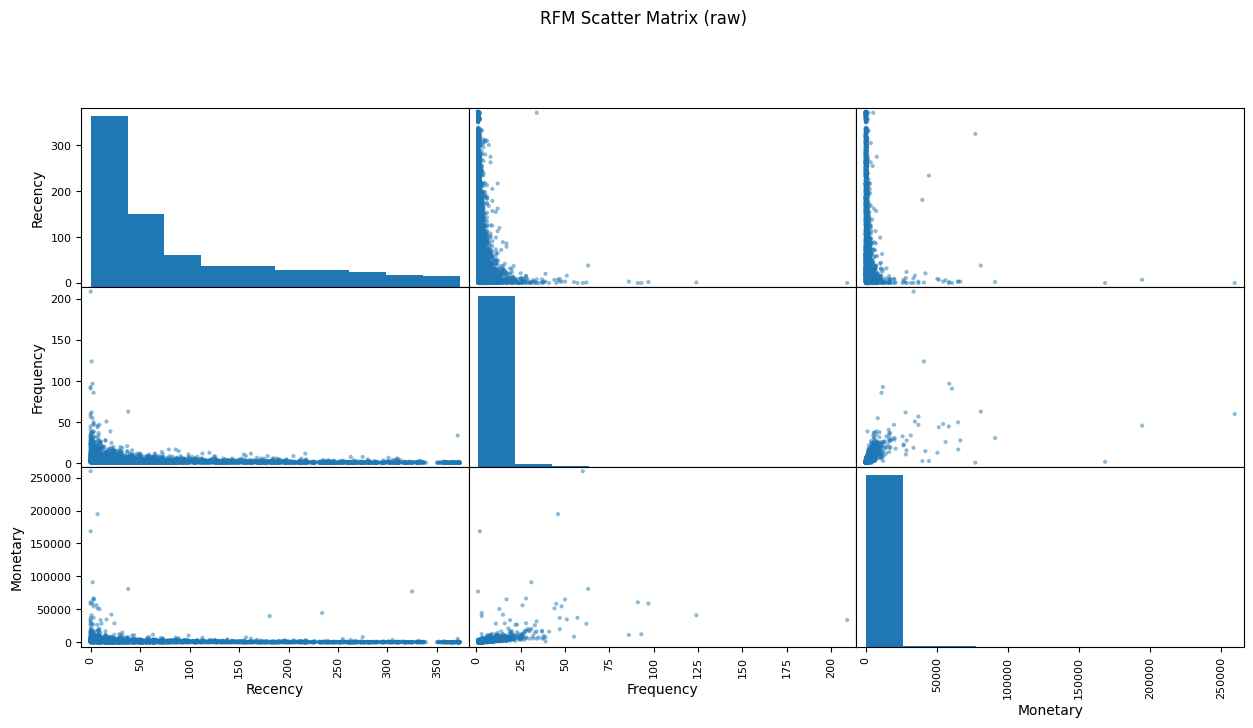

In [12]:
# === Pairplot alternative using pandas scatter_matrix (RAW RFM) ===
from pandas.plotting import scatter_matrix

_ = scatter_matrix(rfm[["Recency", "Frequency", "Monetary"]], figsize=(15, 7), diagonal="hist")
plt.suptitle("RFM Scatter Matrix (raw)", y=1.02)
plt.show()


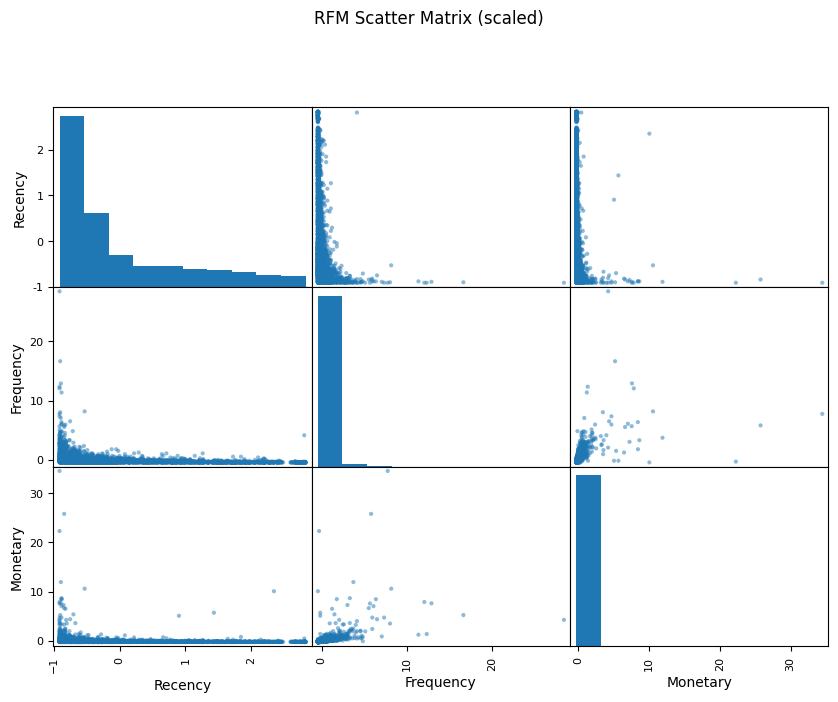

In [13]:
# === Pairplot alternative using pandas scatter_matrix (SCALED RFM) ===
_ = scatter_matrix(rfm_scaled[["Recency", "Frequency", "Monetary"]], figsize=(10, 7), diagonal="hist")
plt.suptitle("RFM Scatter Matrix (scaled)", y=1.02)
plt.show()


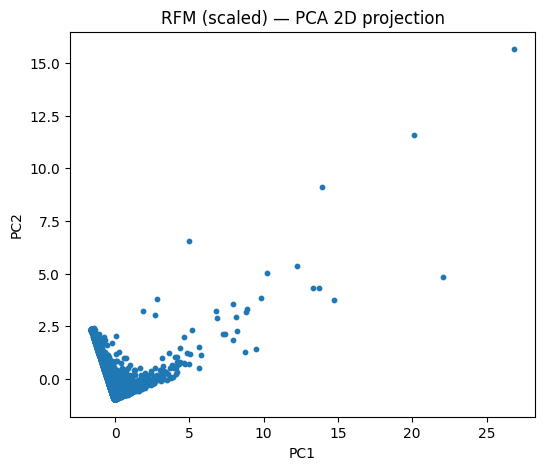

In [14]:
# === Optional: PCA 2D projection for a quick visual of spread ===
from sklearn.decomposition import PCA

X = rfm_scaled[["Recency", "Frequency", "Monetary"]].values
X2 = PCA(n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(6, 5))
plt.scatter(X2[:, 0], X2[:, 1], s=10)
plt.title("RFM (scaled) — PCA 2D projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


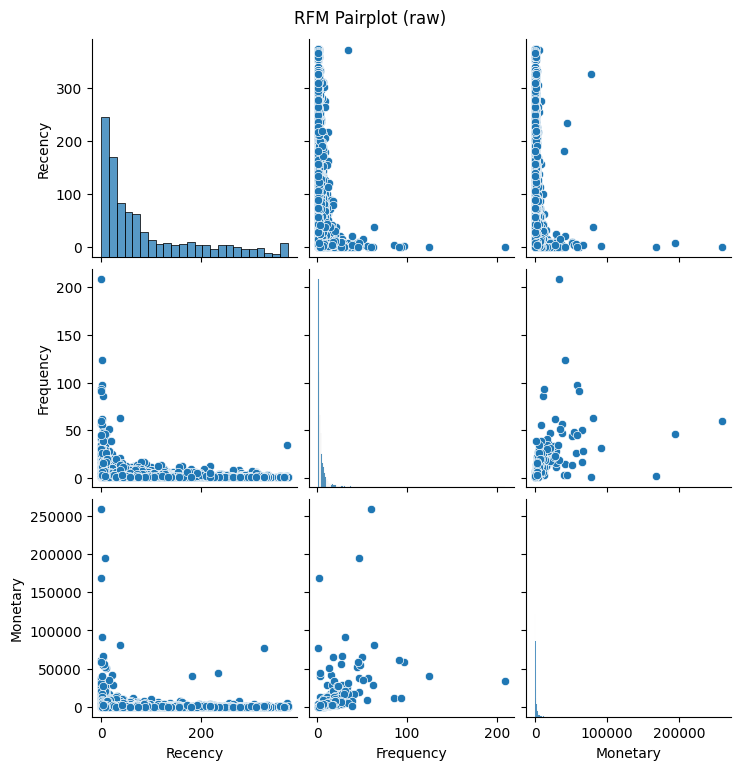

In [15]:
import seaborn as sns
sns.pairplot(rfm[["Recency", "Frequency", "Monetary"]])
plt.suptitle("RFM Pairplot (raw)", y=1.02)
plt.show()


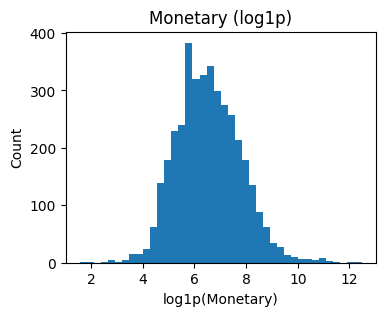

In [16]:
import numpy as np
plt.figure(figsize=(4,3))
plt.hist(np.log1p(rfm["Monetary"].values), bins=40)
plt.title("Monetary (log1p)")
plt.xlabel("log1p(Monetary)")
plt.ylabel("Count")
plt.show()


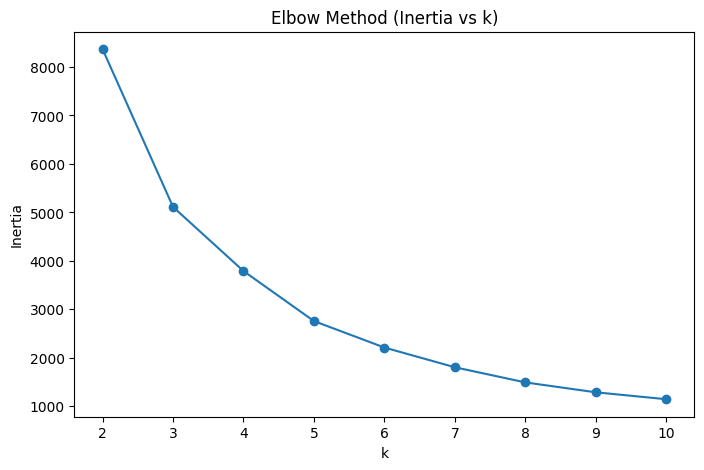

Silhouette by k:


,k,silhouette
0,2,0.886154
1,3,0.580920
2,4,0.595137
3,5,0.600964
4,6,0.593254
5,7,0.514291
6,8,0.483360
7,9,0.483409
8,10,0.417128


Chosen k (fallback by silhouette): 5


In [17]:
# ===== 2.1 K-Means: elbow, metrics, centroids, interpretation =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.decomposition import PCA

# Use scaled RFM for clustering
X = rfm_scaled[["Recency","Frequency","Monetary"]].values

# --- Elbow + Silhouette across k ---
ks = range(2, 11)
inertias, sils = [], []
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X, labels))

# Elbow plot
plt.figure(figsize=(8,5))
plt.plot(list(ks), inertias, marker="o")
plt.title("Elbow Method (Inertia vs k)")
plt.xlabel("k"); plt.ylabel("Inertia"); plt.xticks(list(ks))
plt.show()

# Silhouette by k (helps choose k)
sil_df = pd.DataFrame({"k": list(ks), "silhouette": sils})
print("Silhouette by k:")
display(sil_df)

# Choose k: visually from elbow; fallback = best silhouette
 #int(sil_df.loc[sil_df["silhouette"].idxmax(), "k"])# 
best_k =5
print(f"Chosen k (fallback by silhouette): {best_k}")

# --- Fit final KMeans ---
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
klabels = kmeans.fit_predict(X)



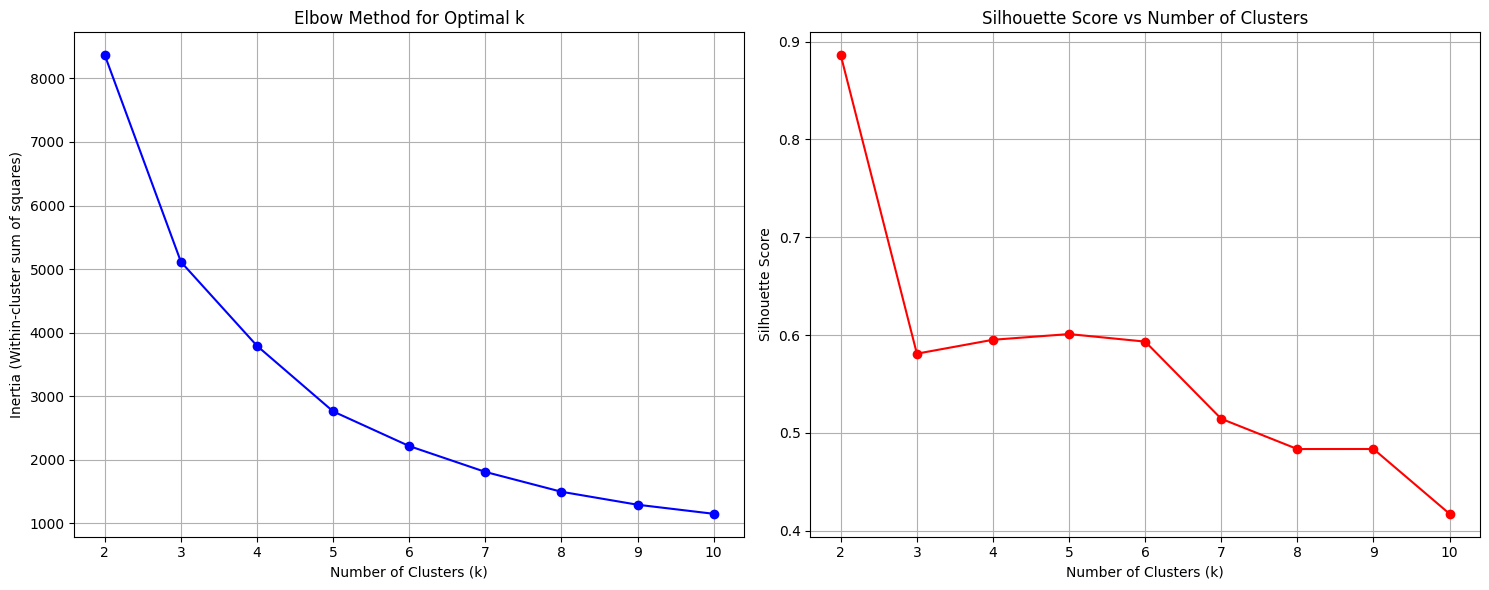

k=2: Silhouette Score = 0.886
k=3: Silhouette Score = 0.581
k=4: Silhouette Score = 0.595
k=5: Silhouette Score = 0.601
k=6: Silhouette Score = 0.593
k=7: Silhouette Score = 0.514
k=8: Silhouette Score = 0.483
k=9: Silhouette Score = 0.483
k=10: Silhouette Score = 0.417


In [18]:
# Elbow Method to find optimal number of clusters
def elbow_method(X, max_k=10):
    inertias = []
    silhouette_scores = []
    K_range = range(2, max_k + 1)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    
    return K_range, inertias, silhouette_scores

# Calculate elbow method metrics
K_range, inertias, silhouette_scores = elbow_method(X)

# Plot Elbow Method results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Elbow curve
ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia (Within-cluster sum of squares)')
ax1.set_title('Elbow Method for Optimal k')
ax1.grid(True)

# Silhouette scores
ax2.plot(K_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs Number of Clusters')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print silhouette scores
for k, score in zip(K_range, silhouette_scores):
    print(f"k={k}: Silhouette Score = {score:.3f}")


Evaluation (k=3)
Silhouette score: 0.5809
Avg intra-cluster distance: 2.9971
Avg inter-centroid distance: 8.9488

K-Means centroids (standardized space):


,Recency,Frequency,Monetary
0,1.53,-0.37,-0.18
1,-0.52,0.06,-0.01
2,-0.73,7.73,9.31


Cluster profile (raw RFM means):


,Recency,Frequency,Monetary
Cluster,,,
0,243.20,1.59,486.92
1,39.88,4.71,1783.47
2,18.39,59.91,71494.41


Segment interpretation (tags):


,Recency,Frequency,Monetary,Segment_Tag
Cluster,,,,
0,243.20,1.59,486.92,"Stale, Low-Freq, Low-Value"
1,39.88,4.71,1783.47,"Mid-Recent, Mid-Freq, Mid-Value"
2,18.39,59.91,71494.41,"Recent, High-Freq, High-Value"


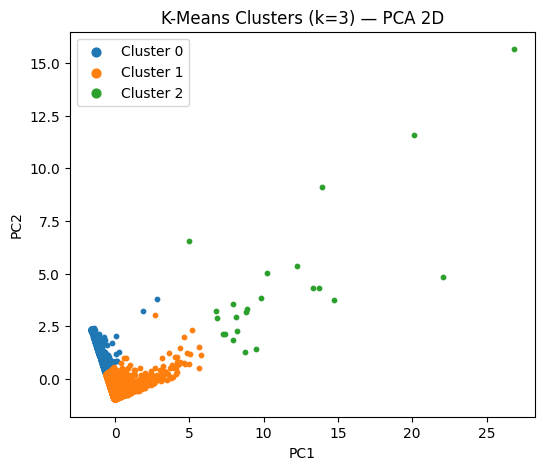

In [19]:
# --- Fit final KMeans ---
best_k =3
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
klabels = kmeans.fit_predict(X)

# --- Metrics: silhouette, intra vs inter centroid distances ---
def intra_inter_scores(X, labels):
    clusters = sorted(list(set(labels)))
    cents = np.vstack([X[labels == c].mean(axis=0) for c in clusters])
    # intra: mean distance of points to their centroid, averaged over clusters
    intra_vals = []
    for c, cent in zip(clusters, cents):
        Xi = X[labels == c]
        intra_vals.append(np.linalg.norm(Xi - cent, axis=1).mean() if len(Xi) else np.nan)
    intra = float(np.nanmean(intra_vals))
    # inter: mean pairwise centroid distance
    if len(cents) > 1:
        D = pairwise_distances(cents)
        inter = float(D[np.triu_indices_from(D, 1)].mean())
    else:
        inter = np.nan
    return intra, inter

sil = silhouette_score(X, klabels)
intra, inter = intra_inter_scores(X, klabels)
print(f"\nEvaluation (k={best_k})")
print(f"Silhouette score: {sil:.4f}")
print(f"Avg intra-cluster distance: {intra:.4f}")
print(f"Avg inter-centroid distance: {inter:.4f}")

# --- Centroids (standardized) ---
centroids_std = pd.DataFrame(kmeans.cluster_centers_, columns=["Recency","Frequency","Monetary"]).round(2)
print("\nK-Means centroids (standardized space):")
display(centroids_std)

# --- Raw RFM means per cluster (easier to interpret) ---
profile = rfm[["Recency","Frequency","Monetary"]].copy()
profile["Cluster"] = klabels
cluster_profile_raw = profile.groupby("Cluster").mean().round(2)
print("Cluster profile (raw RFM means):")
display(cluster_profile_raw)

# --- Quick segment tags for interpretation ---
def label_segments(profile_df):
    L = profile_df.copy()
    # Lower Recency is better (more recent); higher F & M are better
    r_q = np.quantile(L["Recency"], [0.33, 0.66])
    f_q = np.quantile(L["Frequency"], [0.33, 0.66])
    m_q = np.quantile(L["Monetary"], [0.33, 0.66])
    tags = []
    for _, row in L.iterrows():
        r = "Recent" if row["Recency"] <= r_q[0] else ("Mid-Recent" if row["Recency"] <= r_q[1] else "Stale")
        f = "High-Freq" if row["Frequency"] >= f_q[1] else ("Mid-Freq" if row["Frequency"] >= f_q[0] else "Low-Freq")
        m = "High-Value" if row["Monetary"] >= m_q[1] else ("Mid-Value" if row["Monetary"] >= m_q[0] else "Low-Value")
        tags.append(f"{r}, {f}, {m}")
    L["Segment_Tag"] = tags
    return L

print("Segment interpretation (tags):")
display(label_segments(cluster_profile_raw))

# --- PCA 2D visualization of clusters ---
X2 = PCA(n_components=2, random_state=42).fit_transform(X)
plt.figure(figsize=(6,5))
for c in sorted(set(klabels)):
    m = (klabels == c)
    plt.scatter(X2[m,0], X2[m,1], s=10, label=f"Cluster {c}")
plt.title(f"K-Means Clusters (k={best_k}) — PCA 2D")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend(markerscale=2)
plt.show()

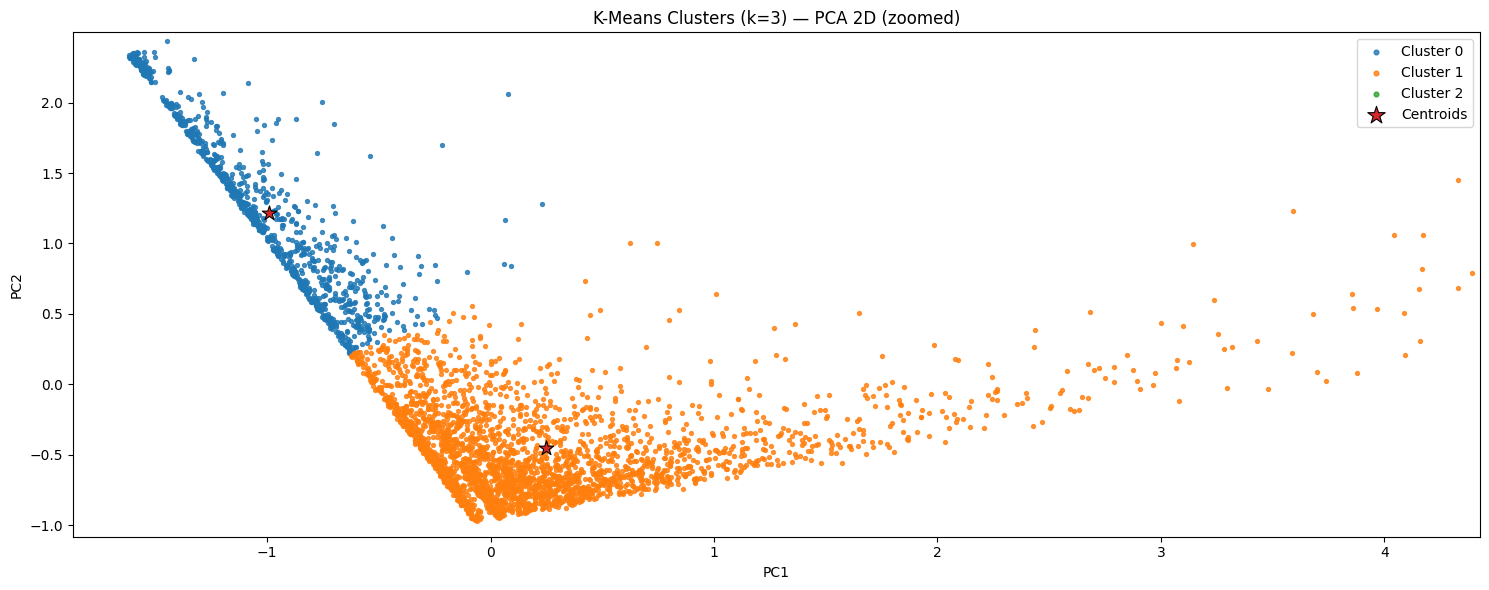

In [20]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

pc = PCA(n_components=2, random_state=42).fit(X)
X2 = pc.transform(X)
centers2 = pc.transform(kmeans.cluster_centers_)

# zoom window (1–99% just for plotting)
x1, x99 = np.percentile(X2[:,0], [1, 99]); y1, y99 = np.percentile(X2[:,1], [1, 99])
xm = 0.05 * (x99 - x1); ym = 0.05 * (y99 - y1)

plt.figure(figsize=(15, 6))  # smaller
for c in sorted(set(klabels)):
    m = (klabels == c)
    plt.scatter(X2[m,0], X2[m,1], s=8, alpha=0.8, label=f"Cluster {c}")  # smaller points

plt.scatter(centers2[:,0], centers2[:,1], s=120, marker='*', edgecolor='k', linewidths=0.8, label='Centroids')

plt.title(f"K-Means Clusters (k={best_k}) — PCA 2D (zoomed)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.xlim(x1 - xm, x99 + xm); plt.ylim(y1 - ym, y99 + ym)
plt.legend(markerscale=1.2)
plt.tight_layout(); plt.show()


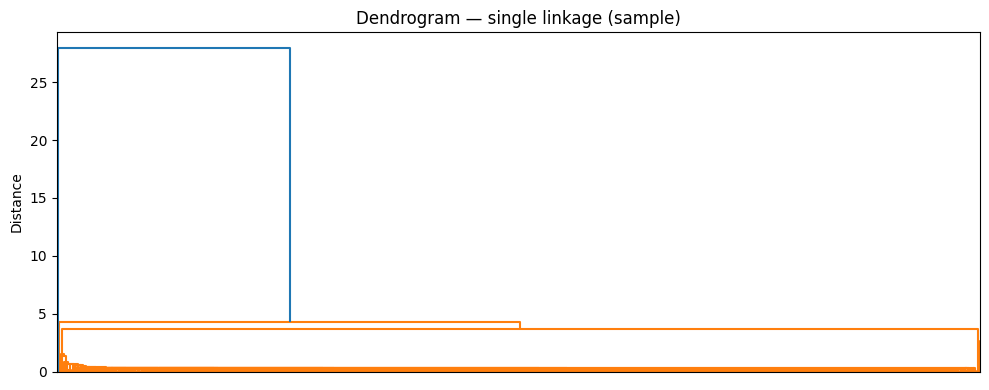

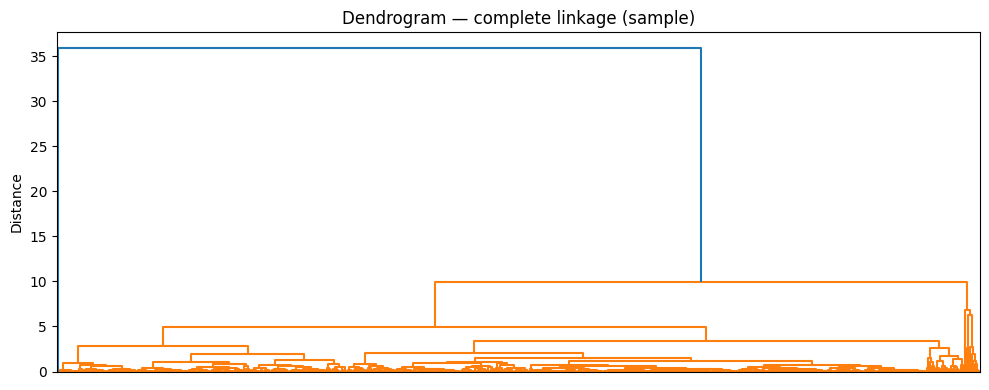

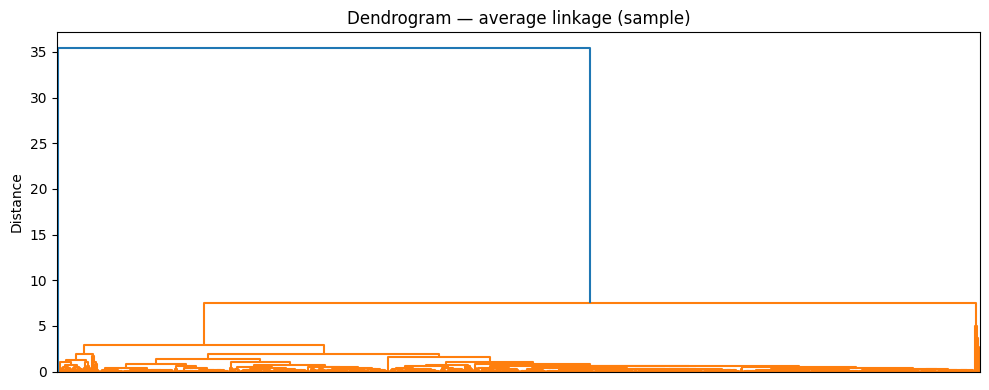

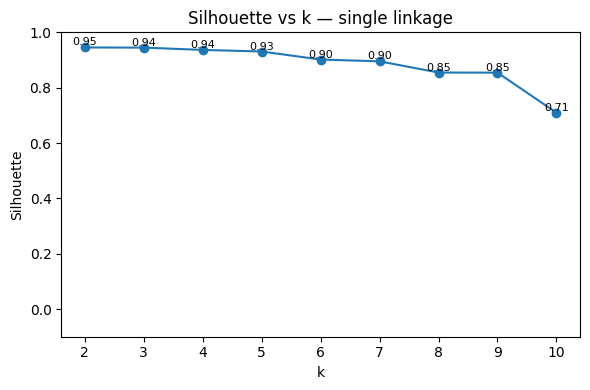


=== AGNES-single — best k=2 ===
Silhouette: 0.9453 | Intra: 0.5484 | Inter: 28.7836
Cluster profile (raw RFM means):


,Recency,Frequency,Monetary
Cluster,,,
0,91.23,4.19,1856.26
1,0.00,209.00,33719.73


Segment tags:


,Recency,Frequency,Monetary,Segment_Tag
Cluster,,,,
0,91.23,4.19,1856.26,"Stale, Low-Freq, Low-Value"
1,0.00,209.00,33719.73,"Recent, High-Freq, High-Value"


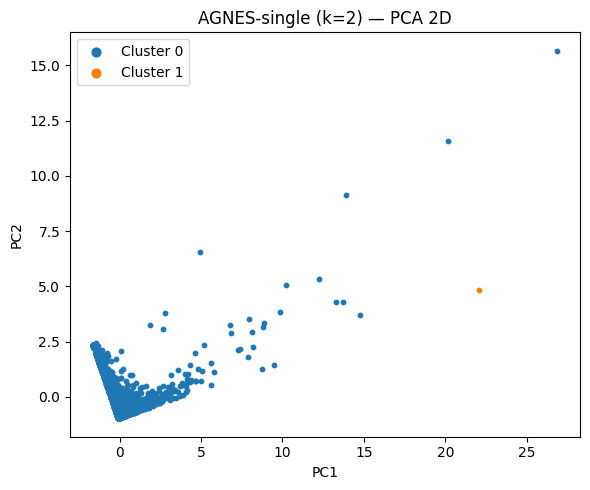

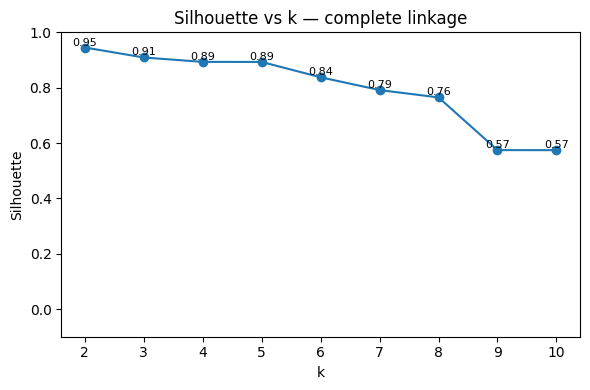


=== AGNES-complete — best k=2 ===
Silhouette: 0.9451 | Intra: 3.3724 | Inter: 27.8799
Cluster profile (raw RFM means):


,Recency,Frequency,Monetary
Cluster,,,
0,91.28,4.22,1706.84
1,2.33,36.00,207560.20


Segment tags:


,Recency,Frequency,Monetary,Segment_Tag
Cluster,,,,
0,91.28,4.22,1706.84,"Stale, Low-Freq, Low-Value"
1,2.33,36.00,207560.20,"Recent, High-Freq, High-Value"


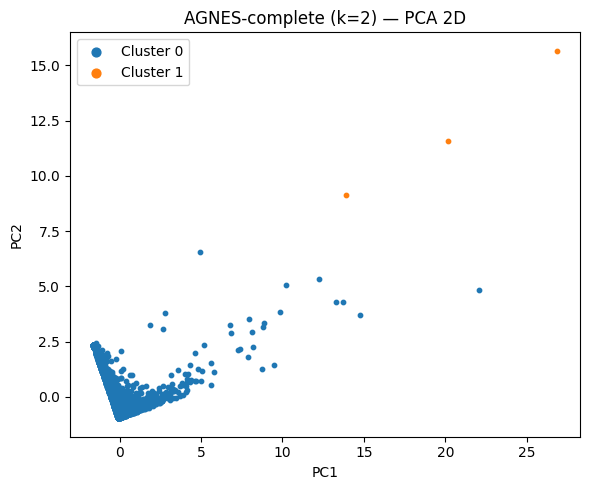

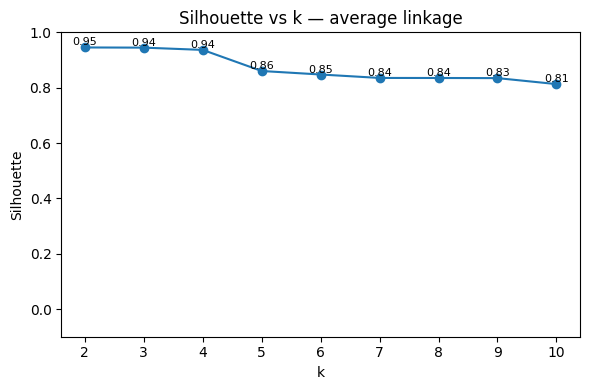


=== AGNES-average — best k=2 ===
Silhouette: 0.9453 | Intra: 0.5484 | Inter: 28.7836
Cluster profile (raw RFM means):


,Recency,Frequency,Monetary
Cluster,,,
0,91.23,4.19,1856.26
1,0.00,209.00,33719.73


Segment tags:


,Recency,Frequency,Monetary,Segment_Tag
Cluster,,,,
0,91.23,4.19,1856.26,"Stale, Low-Freq, Low-Value"
1,0.00,209.00,33719.73,"Recent, High-Freq, High-Value"


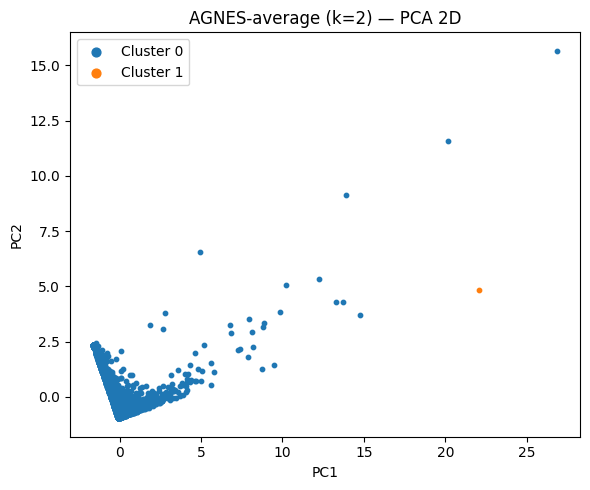


AGNES comparison summary:


,Method,k,Silhouette,Intra,Inter,n_clusters
0,AGNES-single,2,0.945337,0.548391,28.783600,2
2,AGNES-average,2,0.945337,0.548391,28.783600,2
1,AGNES-complete,2,0.945136,3.372425,27.879898,2


In [21]:
# ===== 2.2 Hierarchical Clustering (AGNES) =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.decomposition import PCA

# -------------------- Inputs --------------------
# Use scaled RFM for clustering (assumes you created this in Part 1)
# rfm_scaled: DataFrame with standardized columns ["Recency","Frequency","Monetary"]
# rfm:        DataFrame with raw columns ["Recency","Frequency","Monetary"]

X = rfm_scaled[["Recency","Frequency","Monetary"]].values

# Toggle to annotate silhouette values on the plot
ANNOTATE_SILHOUETTE_POINTS = True

# -------------------- Helpers --------------------
def silhouette_safe(X, labels):
    labs = np.unique(labels)
    if len(labs) < 2:
        return np.nan
    return silhouette_score(X, labels)

def intra_inter_scores(X, labels):
    clusters = sorted(list(set(labels)))
    cents = np.vstack([X[labels == c].mean(axis=0) for c in clusters])
    # intra: mean point→centroid distance per cluster, averaged
    intra_vals = []
    for c, cent in zip(clusters, cents):
        Xi = X[labels == c]
        intra_vals.append(np.linalg.norm(Xi - cent, axis=1).mean() if len(Xi) else np.nan)
    intra = float(np.nanmean(intra_vals)) if len(intra_vals) else np.nan
    # inter: mean pairwise centroid distance
    if len(cents) > 1:
        D = pairwise_distances(cents)
        inter = float(D[np.triu_indices_from(D, 1)].mean())
    else:
        inter = np.nan
    return intra, inter

def profile_clusters(rfm_raw, labels):
    prof = rfm_raw.copy()
    prof["Cluster"] = labels
    return prof.groupby("Cluster")[["Recency","Frequency","Monetary"]].mean().round(2)

def label_segments(profile_df):
    L = profile_df.copy()
    if L.empty: return L
    # Lower Recency is better; higher Frequency/Monetary is better
    r_q = np.quantile(L["Recency"], [0.33, 0.66])
    f_q = np.quantile(L["Frequency"], [0.33, 0.66])
    m_q = np.quantile(L["Monetary"], [0.33, 0.66])
    tags = []
    for _, row in L.iterrows():
        r = "Recent" if row["Recency"] <= r_q[0] else ("Mid-Recent" if row["Recency"] <= r_q[1] else "Stale")
        f = "High-Freq" if row["Frequency"] >= f_q[1] else ("Mid-Freq" if row["Frequency"] >= f_q[0] else "Low-Freq")
        m = "High-Value" if row["Monetary"] >= m_q[1] else ("Mid-Value" if row["Monetary"] >= m_q[0] else "Low-Value")
        tags.append(f"{r}, {f}, {m}")
    L["Segment_Tag"] = tags
    return L

def pca_plot(X, labels, title):
    X2 = PCA(n_components=2, random_state=42).fit_transform(X)
    plt.figure(figsize=(6,5))
    for c in sorted(set(labels)):
        m = (labels == c)
        plt.scatter(X2[m,0], X2[m,1], s=10, label=f"Cluster {c}")
    plt.title(title); plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend(markerscale=2)
    plt.tight_layout(); plt.show()

# -------------------- A) Dendrograms (sample for readability) --------------------
np.random.seed(42)
idx = np.random.choice(len(X), size=min(600, len(X)), replace=False)
X_sample = X[idx]

for method in ["single", "complete", "average"]:
    Z = linkage(X_sample, method=method)  # Euclidean by default
    plt.figure(figsize=(10,4))
    plt.title(f"Dendrogram — {method} linkage (sample)")
    dendrogram(Z, truncate_mode="level", p=700, no_labels=True)
    plt.ylabel("Distance")
    plt.tight_layout(); plt.show()

# -------------------- B) Sweep k and pick best by silhouette per linkage --------------------
def best_agnes_for_linkage(X, linkage_method, k_range=range(2, 11)):
    ks, sils = [], []
    best = (None, -np.inf, None, None)  # (k, sil, model, labels)
    for k in k_range:
        # sklearn version compatibility: metric vs affinity
        try:
            ag = AgglomerativeClustering(n_clusters=k, linkage=linkage_method, metric="euclidean")
        except TypeError:
            ag = AgglomerativeClustering(n_clusters=k, linkage=linkage_method, affinity="euclidean")
        labels = ag.fit_predict(X)
        sil = silhouette_safe(X, labels)
        ks.append(k); sils.append(sil)
        if (not np.isnan(sil)) and sil > best[1]:
            best = (k, sil, ag, labels)

    # Plot silhouette vs k with a fixed y-axis range for easy comparison
    plt.figure(figsize=(6,4))
    plt.plot(list(ks), sils, marker="o")
    plt.title(f"Silhouette vs k — {linkage_method} linkage")
    plt.xlabel("k"); plt.ylabel("Silhouette")
    plt.xticks(list(ks))
    plt.ylim(-0.1, 1.0)  # <<<<< Fixed value range on y-axis (silhouette)
    # Optional: label each point with its silhouette value
    if ANNOTATE_SILHOUETTE_POINTS:
        for xk, val in zip(ks, sils):
            if not np.isnan(val):
                plt.text(xk, val, f"{val:.2f}", ha="center", va="bottom", fontsize=8)
    plt.tight_layout(); plt.show()

    return best, pd.DataFrame({"k": ks, "silhouette": sils})

results = {}
summary_rows = []

for method in ["single", "complete", "average"]:
    (best_k, best_sil, model, labels), sil_tab = best_agnes_for_linkage(X, method)
    intra, inter = intra_inter_scores(X, labels)
    results[method] = {"k": best_k, "silhouette": best_sil, "intra": intra, "inter": inter, "labels": labels}

    print(f"\n=== AGNES-{method} — best k={best_k} ===")
    print(f"Silhouette: {best_sil:.4f} | Intra: {intra:.4f} | Inter: {inter:.4f}")

    # Profiles & tags in RAW units (interpretation)
    prof = profile_clusters(rfm[["Recency","Frequency","Monetary"]], labels)
    print("Cluster profile (raw RFM means):"); display(prof)
    print("Segment tags:"); display(label_segments(prof))

    # PCA scatter
    pca_plot(X, labels, f"AGNES-{method} (k={best_k}) — PCA 2D")

    summary_rows.append({
        "Method": f"AGNES-{method}",
        "k": best_k,
        "Silhouette": float(best_sil) if not np.isnan(best_sil) else np.nan,
        "Intra": float(intra) if not np.isnan(intra) else np.nan,
        "Inter": float(inter) if not np.isnan(inter) else np.nan,
        "n_clusters": len(np.unique(labels))
    })

# -------------------- C) Comparison summary --------------------
summary_df = pd.DataFrame(summary_rows).sort_values("Silhouette", ascending=False)
print("\nAGNES comparison summary:"); display(summary_df)



=== SINGLE linkage (k=2) ===
Silhouette: 0.9453
Intra-cluster distance (↓ better): 0.5484
Inter-cluster distance (↑ better): 28.7836

Cluster profile (RFM means in raw units):


,Recency,Frequency,Monetary
Cluster,,,
0,91.23,4.19,1856.26
1,0.00,209.00,33719.73


Segment tags:


,Segment_Tag
Cluster,
0,"Stale, Low-Freq, Low-Value"
1,"Recent, High-Freq, High-Value"



=== COMPLETE linkage (k=3) ===
Silhouette: 0.9091
Intra-cluster distance (↓ better): 4.0703
Inter-cluster distance (↑ better): 23.2400

Cluster profile (RFM means in raw units):


,Recency,Frequency,Monetary
Cluster,,,
0,1.00,116.67,36275.26
1,2.33,36.00,207560.20
2,91.41,4.05,1653.81


Segment tags:


,Segment_Tag
Cluster,
0,"Recent, High-Freq, Mid-Value"
1,"Mid-Recent, Mid-Freq, High-Value"
2,"Stale, Low-Freq, Low-Value"



=== AVERAGE linkage (k=4) ===
Silhouette: 0.9365
Intra-cluster distance (↓ better): 1.1480
Inter-cluster distance (↑ better): 28.1591

Cluster profile (RFM means in raw units):


,Recency,Frequency,Monetary
Cluster,,,
0,91.3,4.17,1698.67
1,0.0,60.00,259657.30
2,3.5,24.00,181511.64
3,0.0,209.00,33719.73


Segment tags:


,Segment_Tag
Cluster,
0,"Stale, Low-Freq, Low-Value"
1,"Recent, High-Freq, High-Value"
2,"Stale, Mid-Freq, High-Value"
3,"Recent, High-Freq, Mid-Value"



=== Summary (fixed k values) ===


,Method,k,Silhouette,Intra,Inter
0,single,2,0.945337,0.548391,28.783600
1,average,4,0.936513,1.147961,28.159081
2,complete,3,0.909079,4.070311,23.239993


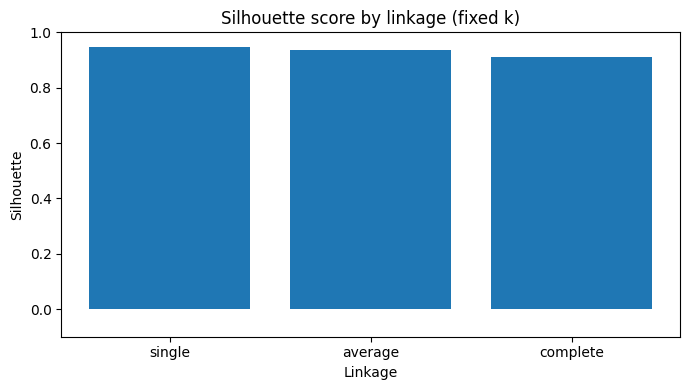

In [22]:
# ===== Part 3: Clustering Evaluation (AGNES with fixed k) =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, pairwise_distances

# ---------- Inputs ----------
X = rfm_scaled[["Recency","Frequency","Monetary"]].values
LINKAGES_K = {"single": 2, "complete": 3, "average": 4}

# ---------- Helpers ----------
def silhouette_safe(X, labels):
    labs = np.unique(labels)
    if len(labs) < 2:
        return np.nan
    return silhouette_score(X, labels)

def intra_inter_scores(X, labels):
    clusters = sorted(list(set(labels)))
    cents = np.vstack([X[labels == c].mean(axis=0) for c in clusters])
    intra_vals = []
    for c, cent in zip(clusters, cents):
        Xi = X[labels == c]
        intra_vals.append(np.linalg.norm(Xi - cent, axis=1).mean() if len(Xi) else np.nan)
    intra = float(np.nanmean(intra_vals)) if len(intra_vals) else np.nan
    if len(cents) > 1:
        D = pairwise_distances(cents)
        inter = float(D[np.triu_indices_from(D, 1)].mean())
    else:
        inter = np.nan
    return intra, inter

def profile_clusters(rfm_raw, labels):
    prof = rfm_raw.copy()
    prof["Cluster"] = labels
    return prof.groupby("Cluster")[["Recency","Frequency","Monetary"]].mean().round(2)

def label_segments(profile_df):
    L = profile_df.copy()
    if L.empty: return L
    r_q = np.quantile(L["Recency"], [0.33, 0.66])
    f_q = np.quantile(L["Frequency"], [0.33, 0.66])
    m_q = np.quantile(L["Monetary"], [0.33, 0.66])
    tags = []
    for _, row in L.iterrows():
        r = "Recent" if row["Recency"] <= r_q[0] else ("Mid-Recent" if row["Recency"] <= r_q[1] else "Stale")
        f = "High-Freq" if row["Frequency"] >= f_q[1] else ("Mid-Freq" if row["Frequency"] >= f_q[0] else "Low-Freq")
        m = "High-Value" if row["Monetary"] >= m_q[1] else ("Mid-Value" if row["Monetary"] >= m_q[0] else "Low-Value")
        tags.append(f"{r}, {f}, {m}")
    L["Segment_Tag"] = tags
    return L

# ---------- Run evaluation with fixed k ----------
rows = []
profiles = {}

for method, k in LINKAGES_K.items():
    # sklearn version compatibility: metric vs affinity
    try:
        ag = AgglomerativeClustering(n_clusters=k, linkage=method, metric="euclidean")
    except TypeError:
        ag = AgglomerativeClustering(n_clusters=k, linkage=method, affinity="euclidean")
    labels = ag.fit_predict(X)

    sil = silhouette_safe(X, labels)
    intra, inter = intra_inter_scores(X, labels)
    prof = profile_clusters(rfm[["Recency","Frequency","Monetary"]], labels)
    tags = label_segments(prof)

    print(f"\n=== {method.upper()} linkage (k={k}) ===")
    print(f"Silhouette: {sil:.4f}")
    print(f"Intra-cluster distance (↓ better): {intra:.4f}")
    print(f"Inter-cluster distance (↑ better): {inter:.4f}")
    print("\nCluster profile (RFM means in raw units):")
    display(prof)
    print("Segment tags:")
    display(tags[["Segment_Tag"]])

    rows.append({
        "Method": method,
        "k": k,
        "Silhouette": sil,
        "Intra": intra,
        "Inter": inter
    })
    profiles[method] = {"labels": labels, "profile": prof, "tags": tags}

summary_df = pd.DataFrame(rows).sort_values("Silhouette", ascending=False).reset_index(drop=True)
print("\n=== Summary (fixed k values) ===")
display(summary_df)

# ---------- Optional: compare silhouette visually ----------
plt.figure(figsize=(7,4))
plt.bar(summary_df["Method"], summary_df["Silhouette"])
plt.title("Silhouette score by linkage (fixed k)")
plt.xlabel("Linkage"); plt.ylabel("Silhouette"); plt.ylim(-0.1, 1.0)
plt.tight_layout(); plt.show()


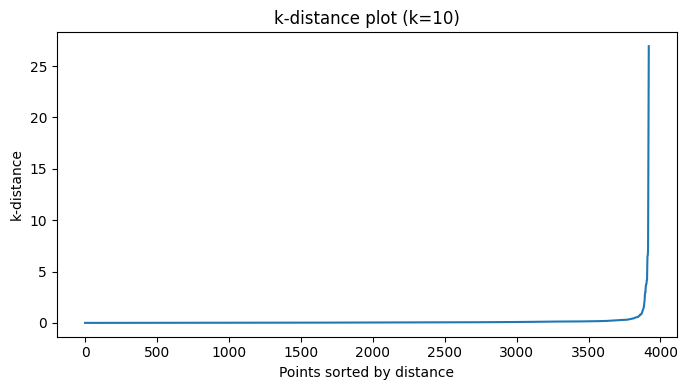

DBSCAN sweep:


,eps,n_clusters,n_noise,silhouette,intra,inter
1,0.142,2,399,-0.117438,0.492916,0.76805
0,0.117,13,604,-0.308268,0.272873,1.14893
2,0.167,1,272,NaN,0.919923,NaN
3,0.191,1,224,NaN,0.929570,NaN
4,0.252,1,166,NaN,0.941605,NaN
5,0.316,1,121,NaN,0.953878,NaN
6,0.578,1,59,NaN,0.980053,NaN



Chosen eps=0.142 (min_samples=10)
DBSCAN → clusters=2, noise=399
Silhouette: -0.1174 | Intra: 0.4929 | Inter: 0.7680
Cluster profile (raw RFM means):


,Recency,Frequency,Monetary
Cluster,,,
0,95.55,2.88,897.55
1,65.44,7.89,1794.60


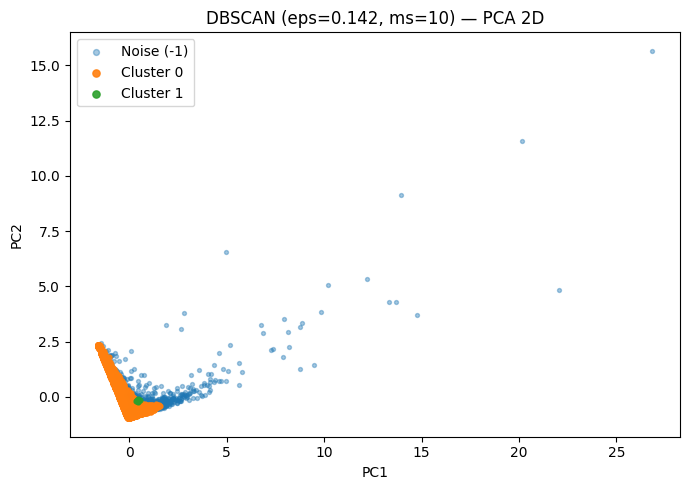

In [23]:
# ===== 2.3 DBSCAN on RFM =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, pairwise_distances

# X = rfm_scaled[["Recency","Frequency","Monetary"]].values  # already defined

# --- Helpers (safe silhouette, intra/inter) ---
def silhouette_safe(X, labels):
    labs = np.setdiff1d(np.unique(labels), [-1])
    if len(labs) < 2:
        return np.nan
    return silhouette_score(X, labels)

def intra_inter_scores(X, labels):
    cats = sorted(list(set(labels) - {-1}))
    if len(cats) == 0:
        return np.nan, np.nan
    cents = np.vstack([X[labels==k].mean(axis=0) for k in cats])
    # intra: mean distance to own centroid
    intra_vals = []
    for k, c in zip(cats, cents):
        Xi = X[labels==k]
        intra_vals.append(np.linalg.norm(Xi - c, axis=1).mean() if len(Xi) else np.nan)
    intra = float(np.nanmean(intra_vals)) if len(intra_vals) else np.nan
    # inter: mean pairwise centroid distance
    if len(cents) > 1:
        D = pairwise_distances(cents)
        inter = float(D[np.triu_indices_from(D, 1)].mean())
    else:
        inter = np.nan
    return intra, inter

def pca_plot_dbscan(X, labels, title):
    X2 = PCA(n_components=2, random_state=42).fit_transform(X)
    plt.figure(figsize=(7,5))
    # Plot noise first (label = -1)
    noise = (labels == -1)
    if noise.any():
        plt.scatter(X2[noise,0], X2[noise,1], s=8, alpha=0.4, label="Noise (-1)")
    # Then clusters
    for c in sorted(set(labels) - {-1}):
        m = (labels == c)
        plt.scatter(X2[m,0], X2[m,1], s=12, alpha=0.9, label=f"Cluster {c}")
    plt.title(title); plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend(markerscale=1.5)
    plt.tight_layout(); plt.show()

# --- Choose min_samples ---
# Rule-of-thumb: max(5, 2*dim). Here dim=3 → 6–12 often works; start at 10.
min_samples = 10

# --- k-distance plot to pick eps (use kth neighbor = min_samples) ---
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X)
distances, _ = nbrs.kneighbors(X)
k_dists = np.sort(distances[:, -1])

plt.figure(figsize=(7,4))
plt.plot(k_dists)
plt.title(f"k-distance plot (k={min_samples})")
plt.xlabel("Points sorted by distance"); plt.ylabel("k-distance")
plt.tight_layout(); plt.show()

# --- Grid search around elbow (quantiles of k_dists) ---
eps_candidates = np.unique(np.round(np.quantile(k_dists, [0.80,0.85,0.90,0.92,0.94,0.96,0.98]), 3))
rows = []
for eps in eps_candidates:
    db = DBSCAN(eps=float(eps), min_samples=min_samples, metric="euclidean")
    labels = db.fit_predict(X)
    n_clusters = len(set(labels) - {-1})
    n_noise = int(np.sum(labels == -1))
    sil = silhouette_safe(X, labels)
    intra, inter = intra_inter_scores(X, labels)
    rows.append([float(eps), n_clusters, n_noise, sil, intra, inter])

res = pd.DataFrame(rows, columns=["eps","n_clusters","n_noise","silhouette","intra","inter"])
print("DBSCAN sweep:")
display(res.sort_values(["silhouette","n_clusters"], ascending=[False,False]))

# --- Pick best eps (prefer >=2 clusters & highest silhouette) ---
valid = res[res["n_clusters"] >= 2]
if len(valid):
    best = valid.sort_values("silhouette", ascending=False).iloc[0]
else:
    best = res.sort_values(["n_clusters","silhouette"], ascending=[False,False]).iloc[0]

best_eps = float(best["eps"])
print(f"\nChosen eps={best_eps} (min_samples={min_samples})")

# --- Final model, metrics, profiles, plot ---
db = DBSCAN(eps=best_eps, min_samples=min_samples, metric="euclidean")
labels = db.fit_predict(X)

sil = silhouette_safe(X, labels)
intra, inter = intra_inter_scores(X, labels)
print(f"DBSCAN → clusters={len(set(labels)-{-1})}, noise={int(np.sum(labels==-1))}")
print(f"Silhouette: {sil:.4f} | Intra: {intra:.4f} | Inter: {inter:.4f}")

# Raw RFM means per cluster (skip noise)
profile = rfm[["Recency","Frequency","Monetary"]].copy()
profile["Cluster"] = labels
prof = profile[profile["Cluster"]!=-1].groupby("Cluster").mean().round(2)
print("Cluster profile (raw RFM means):"); display(prof)

# Visualize with noise highlighted
pca_plot_dbscan(X, labels, f"DBSCAN (eps={best_eps}, ms={min_samples}) — PCA 2D")


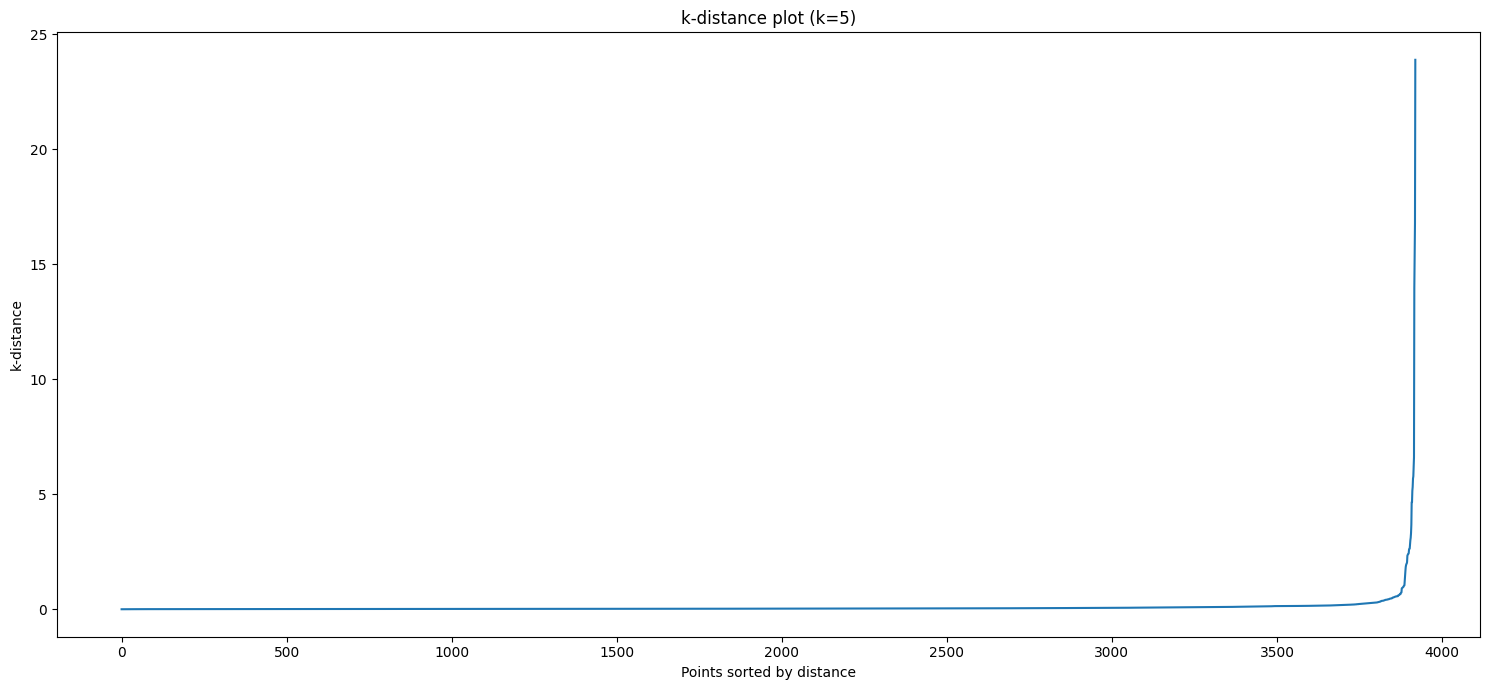

DBSCAN sweep:


,eps,n_clusters,n_noise,silhouette,intra,inter
5,0.251,3,122,0.551317,0.405487,2.300658
4,0.175,3,179,0.318082,0.384109,1.994741
3,0.152,5,231,0.120636,0.261516,2.355271
2,0.141,6,281,-0.228602,0.230303,1.651631
1,0.100,26,471,-0.346100,0.167975,1.390565
0,0.075,28,637,-0.390871,0.138413,1.280524
6,0.451,1,65,NaN,0.981316,NaN



Chosen eps=0.251 (min_samples=5)
DBSCAN → clusters=3, noise=122
Silhouette: 0.5513 | Intra: 0.4055 | Inter: 2.3007
Cluster profile (raw RFM means):


,Recency,Frequency,Monetary
Cluster,,,
0,92.85,3.43,1145.56
1,4.17,24.83,5192.50
2,8.00,25.40,8402.22


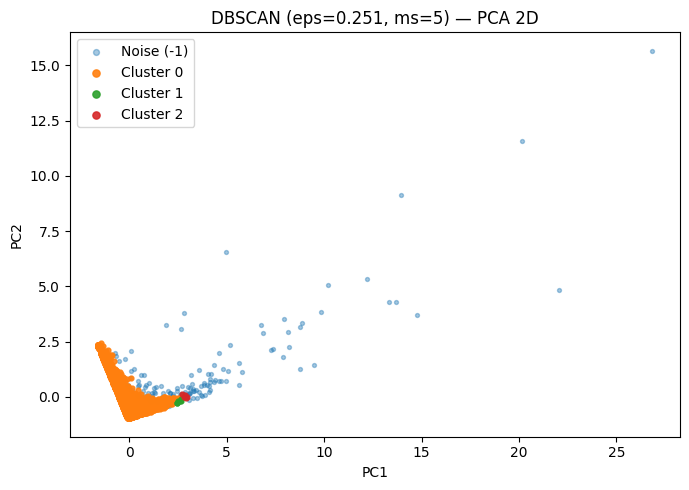

In [24]:
# ===== 2.3 DBSCAN on RFM =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, pairwise_distances

# X = rfm_scaled[["Recency","Frequency","Monetary"]].values  # already defined

# --- Helpers (safe silhouette, intra/inter) ---
def silhouette_safe(X, labels):
    labs = np.setdiff1d(np.unique(labels), [-1])
    if len(labs) < 2:
        return np.nan
    return silhouette_score(X, labels)

def intra_inter_scores(X, labels):
    cats = sorted(list(set(labels) - {-1}))
    if len(cats) == 0:
        return np.nan, np.nan
    cents = np.vstack([X[labels==k].mean(axis=0) for k in cats])
    # intra: mean distance to own centroid
    intra_vals = []
    for k, c in zip(cats, cents):
        Xi = X[labels==k]
        intra_vals.append(np.linalg.norm(Xi - c, axis=1).mean() if len(Xi) else np.nan)
    intra = float(np.nanmean(intra_vals)) if len(intra_vals) else np.nan
    # inter: mean pairwise centroid distance
    if len(cents) > 1:
        D = pairwise_distances(cents)
        inter = float(D[np.triu_indices_from(D, 1)].mean())
    else:
        inter = np.nan
    return intra, inter

def pca_plot_dbscan(X, labels, title):
    X2 = PCA(n_components=2, random_state=42).fit_transform(X)
    plt.figure(figsize=(7,5))
    # Plot noise first (label = -1)
    noise = (labels == -1)
    if noise.any():
        plt.scatter(X2[noise,0], X2[noise,1], s=8, alpha=0.4, label="Noise (-1)")
    # Then clusters
    for c in sorted(set(labels) - {-1}):
        m = (labels == c)
        plt.scatter(X2[m,0], X2[m,1], s=12, alpha=0.9, label=f"Cluster {c}")
    plt.title(title); plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend(markerscale=1.5)
    plt.tight_layout(); plt.show()

# --- Choose min_samples ---
# Rule-of-thumb: max(5, 2*dim). Here dim=3 → 6–12 often works; start at 10.
min_samples = 5

# --- k-distance plot to pick eps (use kth neighbor = min_samples) ---
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X)
distances, _ = nbrs.kneighbors(X)
k_dists = np.sort(distances[:, -1])

plt.figure(figsize=(15,7))
plt.plot(k_dists)
plt.title(f"k-distance plot (k={min_samples})")
plt.xlabel("Points sorted by distance"); plt.ylabel("k-distance")
plt.tight_layout(); plt.show()

# --- Grid search around elbow (quantiles of k_dists) ---
eps_candidates = np.unique(np.round(np.quantile(k_dists, [0.80,0.85,0.90,0.92,0.94,0.96,0.98]), 3))
rows = []
for eps in eps_candidates:
    db = DBSCAN(eps=float(eps), min_samples=min_samples, metric="euclidean")
    labels = db.fit_predict(X)
    n_clusters = len(set(labels) - {-1})
    n_noise = int(np.sum(labels == -1))
    sil = silhouette_safe(X, labels)
    intra, inter = intra_inter_scores(X, labels)
    rows.append([float(eps), n_clusters, n_noise, sil, intra, inter])

res = pd.DataFrame(rows, columns=["eps","n_clusters","n_noise","silhouette","intra","inter"])
print("DBSCAN sweep:")
display(res.sort_values(["silhouette","n_clusters"], ascending=[False,False]))

# --- Pick best eps (prefer >=2 clusters & highest silhouette) ---
valid = res[res["n_clusters"] >= 2]
if len(valid):
    best = valid.sort_values("silhouette", ascending=False).iloc[0]
else:
    best = res.sort_values(["n_clusters","silhouette"], ascending=[False,False]).iloc[0]

best_eps = float(best["eps"])
print(f"\nChosen eps={best_eps} (min_samples={min_samples})")

# --- Final model, metrics, profiles, plot ---
db = DBSCAN(eps=best_eps, min_samples=min_samples, metric="euclidean")
labels = db.fit_predict(X)

sil = silhouette_safe(X, labels)
intra, inter = intra_inter_scores(X, labels)
print(f"DBSCAN → clusters={len(set(labels)-{-1})}, noise={int(np.sum(labels==-1))}")
print(f"Silhouette: {sil:.4f} | Intra: {intra:.4f} | Inter: {inter:.4f}")

# Raw RFM means per cluster (skip noise)
profile = rfm[["Recency","Frequency","Monetary"]].copy()
profile["Cluster"] = labels
prof = profile[profile["Cluster"]!=-1].groupby("Cluster").mean().round(2)
print("Cluster profile (raw RFM means):"); display(prof)

# Visualize with noise highlighted
pca_plot_dbscan(X, labels, f"DBSCAN (eps={best_eps}, ms={min_samples}) — PCA 2D")
